# Ultimate Technologies Time series Analysis and Forecasting


### 1. Sourcing and Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_json('logins.json')
data.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


### 2. Data Wrangling

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


There are no nulls, the `login_time` is already formatted correctly.  Check the range of the logins.

In [4]:
print(f'Login datetime range:\n{data.login_time.min()} : {data.login_time.max()}')

Login datetime range:
1970-01-01 20:12:16 : 1970-04-13 18:57:38


The logins time series covers 3 months and two weeks.  Time for aggregation.

In [5]:
### set index as datetime, resample to 15 minute intervals with 
### count of logins for each window
data = data.set_index('login_time',drop=False)
d15 = data.resample('15T').count()
d15.head()

,login_time
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


### 3. EDA

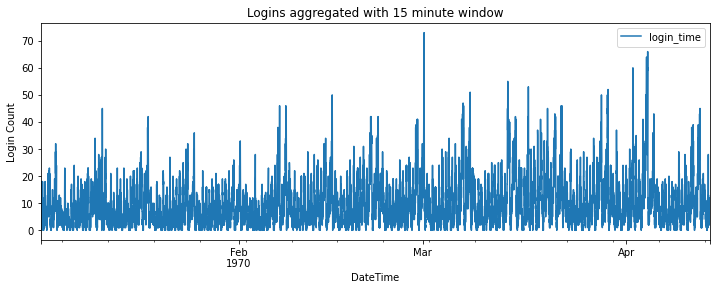

In [6]:
### Plot of 15 min aggregated logins through time
d15.plot(kind='line',y='login_time',figsize=(12,4))
plt.ylabel('Login Count')
plt.xlabel('DateTime')
plt.title('Logins aggregated with 15 minute window')
plt.show()

The above plot shows the login time series aggregated using a 15 min window.  The series is noisy with many sharp spikes and it is difficult to discern any trends.

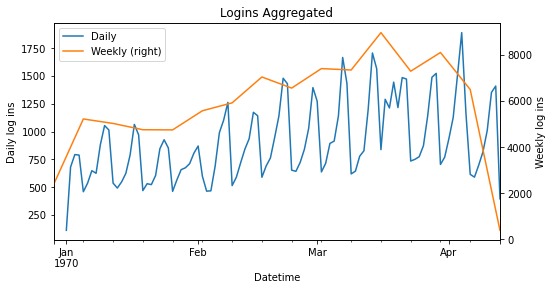

In [7]:
### Aggregating every hour to see if any data issues show up

ax = data.resample('1D').count().plot(kind='line',y='login_time',label='Daily',figsize=(8,4))


ax2 = data.resample('1W').count().plot(kind='line',y='login_time',label='Weekly',ax=ax,secondary_y=True)

ax.set_ylabel('Daily log ins')
ax.set_xlabel('Datetime')
ax2.set_ylabel('Weekly log ins')


plt.title('Logins Aggregated')

handles,labels = [],[]
for axx in [ax,ax2]:
    for h,l in zip(*axx.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

#plt.legend(handles,labels)

plt.show()

The above plot shows daily and weekly aggregated log ins.  The daily and weekly curves are useful for seeing trends in the data.  The log ins start to increase in February and then peak in mid-March.  By the start of April the daily log ins are on the decline.  
___
Now a few plots looking at the log ins per day of the week and at different times of day.  

In [8]:
d15['day'] = d15.index.day_of_year
d15['dow'] = d15.index.day_of_week
d15['month'] = d15.index.month
d15['week'] = d15.index.week
d15['hour'] = d15.index.hour
d15['time'] = d15.index.hour + d15.index.minute/60 + d15.index.second/360

C:\Users\blain\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  after removing the cwd from sys.path.


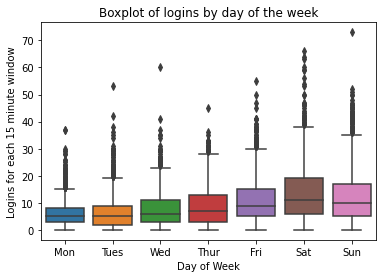

In [9]:
### Distribution by day of week
import seaborn as sns

sns.boxplot(data=d15,y='login_time',x='dow')

plt.xticks(ticks = [0,1,2,3,4,5,6],labels=['Mon','Tues','Wed','Thur','Fri','Sat','Sun'])
plt.xlabel('Day of Week')
plt.ylabel('Logins for each 15 minute window')
plt.title('Boxplot of logins by day of the week')

plt.show()



The boxplots above show that there tend to be more log ins on Friday, Saturday, and Sunday than there are the other 4 days of the week, with a peak on Saturdays. 

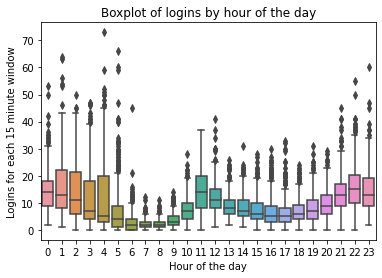

In [10]:
sns.boxplot(data=d15,y='login_time',x='hour')


plt.xlabel('Hour of the day')
plt.ylabel('Logins for each 15 minute window')
plt.title('Boxplot of logins by hour of the day')

plt.show()

This is not what I expected to see.  There tend to be more visitors at 1 am than at any other time of day?  ~~It's possible that these log ins are from a different location in a different time zone, in which case I would like to convert them to local time.  I do not have information on this so I will proceed assuming the times are correct.~~~ According to the documentaion this time series includes logins from Gotham, which is mostly active at night.  Proceeding.


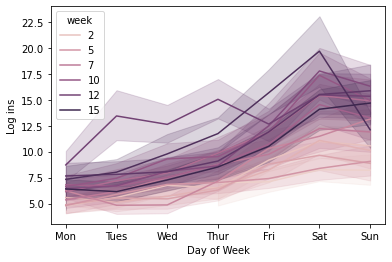

In [11]:
### plotting the log ins over each week
sns.lineplot(data=d15,x='dow',y='login_time',hue='week')
plt.xticks(ticks = [0,1,2,3,4,5,6],labels=['Mon','Tues','Wed','Thur','Fri','Sat','Sun'])
plt.xlabel('Day of Week')
plt.ylabel('Log ins')
plt.show()

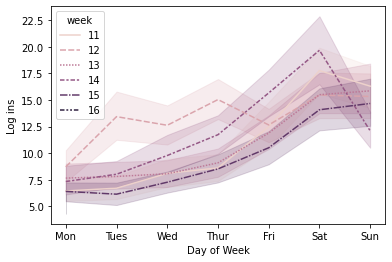

In [12]:
### reducing the number of lines on the plot for ease of interpretation
sns.lineplot(data=d15[d15.week>10],x='dow',y='login_time',hue='week',style='week')
plt.xticks(ticks = [0,1,2,3,4,5,6],labels=['Mon','Tues','Wed','Thur','Fri','Sat','Sun'])
plt.xlabel('Day of Week')
plt.ylabel('Log ins')
plt.show()

The above line plots show that in week 12 there were anomalously high log in counts on Tuesday, Wednesday and Thursday. This is visible as an interuption to the usual weekly periodicity in the daily aggregated curve in cell 6.  

The above also shows that week 14 had higher than normal log in values Thursday through Saturday.  

Now looking for outliers

In [13]:
### quick look for outliers by comparing to the mean and standard deviation 
### for that time window across all days in the data

d15['timewin_mean'] = d15.groupby('time')['login_time'].transform('mean')
d15['timewin_std'] = d15.groupby('time')['login_time'].transform('std')
d15['stds_from_mean'] = abs((d15.login_time - d15.timewin_mean)/d15.timewin_std)
#d15.head()
d15[d15.stds_from_mean>5]


,login_time,day,dow,month,week,hour,time,timewin_mean,timewin_std,stds_from_mean
login_time,,,,,,,,,,
1970-02-23 08:15:00,11,54,0,2,9,8,8.25,1.754902,1.731686,5.338783
1970-03-14 17:45:00,33,73,5,3,11,17,17.75,6.774510,5.189301,5.053761
1970-04-01 23:30:00,60,91,2,4,14,23,23.50,14.274510,8.750849,5.225263
1970-04-03 12:45:00,34,93,4,4,14,12,12.75,10.303922,4.420450,5.360558
1970-04-04 05:15:00,59,94,5,4,14,5,5.25,7.549020,9.715383,5.295826
1970-04-04 05:30:00,66,94,5,4,14,5,5.50,5.343137,8.323288,7.287608
1970-04-04 05:45:00,41,94,5,4,14,5,5.75,4.480392,5.739787,6.362537
1970-04-04 06:00:00,45,94,5,4,14,6,6.00,3.617647,5.709197,7.248366
1970-04-04 06:15:00,21,94,5,4,14,6,6.25,3.137255,3.546129,5.037251


There are 11 cases of the windowed log in count more than 5 standard deviations from the mean.  Most of these occured in week 14 and there is a group early in the morning of April 4th.  There must have been something anomalous happening that day.  These values probably created the peak of the week 14 curve on Saturday in the plot above.  

The other anomalous values, don't appear to be in any group and they are only slightly more that 5 std's from the mean, so I will leave all of these log in counts for now.  

### Part 1 Summary
The log in time series covers 3 months and two weeks of activity, from Jan. 1st 1970 to April 13th, 1970.  Long term trends show the number of logins begins increasing around February 1st and peaks in mid-March before decreasing.  

There tend to be more Logins on Fridays, Saturdays and Sundays than on Monday through Thursdays.  

Daily there are tend to be more log ins in the overnight hours between 10 pm and 4 am and much fewer logins in the hours of 6-10 am.  There is another uptick in the log ins during lunch time from 11 am - 1 pm.

Looking at the log in trend for each week there are 2 anomalies identified.  During week 12 there is a greater number of log ins on Tuesday, Wednesday and Thursday relative to the normal amount.  In Week 14 there are increased log ins on Thursday, Friday, and Saturday.  

There are 11 examples of anomalous values, where the log in count is more than 5 standard deviations from the mean for that 15 min window across all days in the data.  Most of these occur in the early morning hours of April 3rd. Maybe April 3rd is a holiday in Gotham?

### Part 2 - Experiment and Metric Design
#### Problem:
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1.  What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric? 
    1. __The metric I choose to test is the average wait time between ride request and and ride pick up.  A significant decrease in this value would mean there are more drivers avaliable in the areas of the highest demand.  Ultimate's reimbursing of toll costs should enable drivers to gravitate to these areas of elevated demand.  From the rider's perspective a decrease in wait time is obviously preferred and it means less unproductive time for drivers.  From Ultimate's perspective it means happy customers and drivers helping to increase Ultimate's market share.  A secondary metric to look at is the total number of completed rides in a day.  If the wait time is too long customers will find an alternative, resulting in fewer Ultimate rides and less revenue for Ultimate.__
1.  Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. 
    1. __H(0): Reimbursing drivers toll payments will result in no change to the average wait time between ride request and ride pickup__
    1. __H(A): Reimbursing drivers toll payments will result in a decrease of the average wait time between ride request and ride pickup__
    1.  __To conduct this experiment I would randomly split the days of the time frame into control and reimbursement days ensuring that there are equal number of weekdays and weekend days in the both groups.  To determine how long the experiment should be I really need to know specific numbers, but I'll say one month for now.  So during this month drivers will have tolls reimbursed for half the days and for the other half they will not.  A relatively long time frame is needed, because we do not want the results to be skewed by one-off events.  Randomization is needed to reduce bias and any other confounding effects.__
    1.  __To verify the significance of the experiment I will conduct a one sided permutation test.  First calculating the observed mean wait times for all control days and all reimbursement days in the experiment and taking the difference.  Then permutating the control group and reimbursement group several thousand times, calculating the resulting difference in wait time means for each.  If the observerd difference from the experiment is greater than 95% of permutation calculations than I can reject the null hypothesis.__
    1. __If I can reject the null hypothesis I can say with 95% certainty that the reimbursing drivers tolls resulted in a decrease of the average wait time.  As far as recommendations go it depends on what the goals of the operations team are.  If the goal is to increase revenue recommendations will depend on experiments effect on revenue and the cost of reimbursing tolls for drivers.  If the goal is to expand market share, we will need to look at ride metrics compared to historical data and our competition during the experiment to determine if it was a success.  After that discussion I will be able to recommend a path forward.__
    1.  __If the test fails to reject the null hypothesis I can conclude that reimbursing drivers tolls had no significant effect on wait times.  In that case, we can start to look at other experiments to increase revenue or market share.__
    

### Part 3 - Predictive Modelling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. 

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

In [14]:
data = pd.read_json('ultimate_data_challenge.json')
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


#### Cleaning

In [16]:
data['signup_date'] = pd.to_datetime(data.signup_date,format="%Y-%m-%d")
data['last_trip_date'] = pd.to_datetime(data.last_trip_date,format="%Y-%m-%d")

In [17]:
max_last_date = data.last_trip_date.max()
max_last_date

Timestamp('2014-07-01 00:00:00')

Ok assuming the data was pulled on July 1st 2014 then I can determine retention by seeing if a user had a ride in the 30 days prior to that.

In [18]:
data['last_trip_days_from_max'] = max_last_date - data.last_trip_date
data['last_trip_days_from_max'] = data.last_trip_days_from_max.dt.days
data['retention'] = 1 * (data.last_trip_days_from_max<30)

data.drop('last_trip_days_from_max',axis=1,inplace=True)

print('Fraction of users retained')
data.retention.value_counts()/data.shape[0]


Fraction of users retained


0    0.6338
1    0.3662
Name: retention, dtype: float64

Of the users that signed up in January 2014, by July 2014 only 36.6% of those users were retained.  Now that I have the target I need to check the formatting and go about filling in null values. 

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
 12  retention               50000 non-null  int32 

In [20]:
### turn 'ultimate_black_user', into 0's and 1's
data['ultimate_black_user'] = 1*data.ultimate_black_user

In [21]:
### fill nulls in `avg_rating_of_driver' with median of that users city.
### ditto for 'avg_rating_by_driver'
for c in ['avg_rating_of_driver','avg_rating_by_driver']:
    data[c] = data[c].fillna(data.groupby('city')[c].transform('median'))

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  int32         
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  retention               50000 non-null  int32 

In [23]:
data.phone.value_counts()/data.shape[0]


iPhone     0.69164
Android    0.30044
Name: phone, dtype: float64

In [24]:
print(data.phone.isna().sum())
print(f'{100*data.phone.isna().sum()/data.shape[0]:.2f}% of all records')

396
0.79% of all records


There are 396 cases of the phone OS being null.  I could give them another category or I could drop them completely.  Let's check the retention status of these users.  

In [25]:
data.loc[data.phone.isna(),'retention'].value_counts() / data.loc[data.phone.isna(),'retention'].shape[0]

0    0.671717
1    0.328283
Name: retention, dtype: float64

The retention rate for these users is very similar to the overall numbers. Since these users represent less than 1% of the data I will drop them, and turn the `phone` column into binary (1 for iPhone). 

In [26]:
data = data[data.phone.isna()!=True]

In [27]:
data['phone'] = 1 * (data.phone=='iPhone')
data = data.rename(columns={'phone':'iPhone'})

#### EDA

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49604 non-null  object        
 1   trips_in_first_30_days  49604 non-null  int64         
 2   signup_date             49604 non-null  datetime64[ns]
 3   avg_rating_of_driver    49604 non-null  float64       
 4   avg_surge               49604 non-null  float64       
 5   last_trip_date          49604 non-null  datetime64[ns]
 6   iPhone                  49604 non-null  int32         
 7   surge_pct               49604 non-null  float64       
 8   ultimate_black_user     49604 non-null  int32         
 9   weekday_pct             49604 non-null  float64       
 10  avg_dist                49604 non-null  float64       
 11  avg_rating_by_driver    49604 non-null  float64       
 12  retention               49604 non-null  int32 

In [29]:
data.retention.value_counts()/data.shape[0]

0    0.633497
1    0.366503
Name: retention, dtype: float64

In the cleaned up data 36.6% of useres were retained.  Now I will profile the columns below in the following order.
1.  Categorical `city` 
1.  Boolean columns `iPhone` and `ultimate_black_user`
1.  Datetime columns `signup_date` and `last_trip_date`
1.  Numeric columns the rest

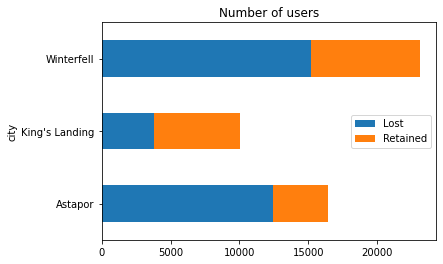

city chi2: 3978.836, pval: 0.000


In [30]:
by_city = data.groupby(['city','retention'])[['iPhone']].count().reset_index(level=1).pivot(columns='retention',values='iPhone')
by_city.plot(kind='barh',stacked=True)

plt.legend(loc='right',labels=['Lost','Retained'])
plt.title('Number of users')
plt.bar_label
plt.show()

from scipy.stats import chi2_contingency
chi2, pval, dof, exp = chi2_contingency( pd.crosstab(data.city,data.retention) )
print(f'city chi2: {chi2:.3f}, pval: {pval:.3f}')

King's Landing has a lower number of users, but a much higher rate of retention. Astapor has the lowest rate of retention. This looks useful for prediction and I will one hot encode it now. 

In [31]:
data = pd.get_dummies(data,columns=['city'])

Done. Now boolean's.

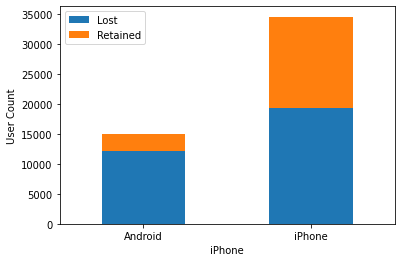

city chi2: 2701.775, pval: 0.000


In [32]:
data.groupby(['iPhone','retention'])[['surge_pct']].count().reset_index(level=1).pivot(columns='retention',values='surge_pct').plot(kind='bar',stacked=True)
plt.xticks([0,1],labels=['Android','iPhone'],rotation=0)
plt.ylabel('User Count')
plt.legend(labels=['Lost','Retained'])
plt.show()

chi2, pval, dof, exp = chi2_contingency( pd.crosstab(data.iPhone,data.retention) )
print(f'city chi2: {chi2:.3f}, pval: {pval:.3f}')

The users on iPhones are much more likely to be retained.

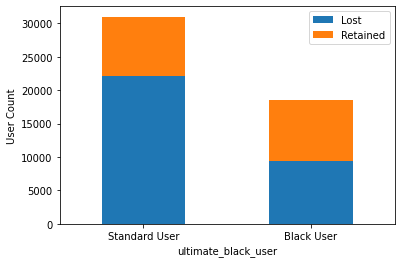

city chi2: 2225.320, pval: 0.000


In [33]:
data.groupby(['ultimate_black_user','retention'])[['surge_pct']].count().reset_index(level=1).pivot(columns='retention',values='surge_pct').plot(kind='bar',stacked=True)
plt.xticks([0,1],labels=['Standard User','Black User'],rotation=0)
plt.ylabel('User Count')
plt.legend(labels=['Lost','Retained'])
plt.show()

chi2, pval, dof, exp = chi2_contingency( pd.crosstab(data.ultimate_black_user,data.retention) )
print(f'city chi2: {chi2:.3f}, pval: {pval:.3f}')

There are fewer of them, but the users who use Ultimate Black in the first 30 days since joining are more likely to be retained. These 2 boolean columns look to be useful. 
___
Date columns.  `signup_date` indicates what day of January 2014 that the user signed up on.  `last_trip_date` is indicates when last trip the user took and is used in calculation of the target.   

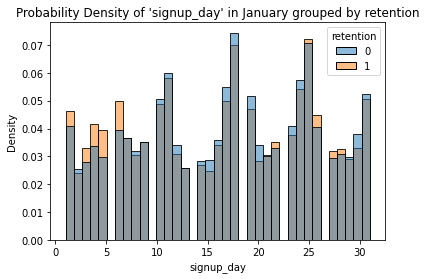

In [34]:
data['signup_day'] = data.signup_date.dt.day
sns.histplot(data=data, x='signup_day', hue='retention',stat='density',common_norm=False)
plt.title("Probability Density of 'signup_day' in January grouped by retention")
plt.show()

In [35]:
chi2, pval, dof, exp = chi2_contingency(pd.crosstab(data.signup_day, data.retention))
print(f'signup_day chi2: {chi2:.3f}, pvalue: {pval:.3f}')

signup_day chi2: 131.548, pvalue: 0.000


Above are the normalized histograms for sign up day for retained and not retained users.  From the visual there doesn't appear to be much difference, but the chi2 test says there is an association.
___
The target `retained` is calculated from the other datetime column.  Therefore it would be cheating to use this column for prediction of the target.  I will drop it before modelling. 
___ 
Now for the numeric columns

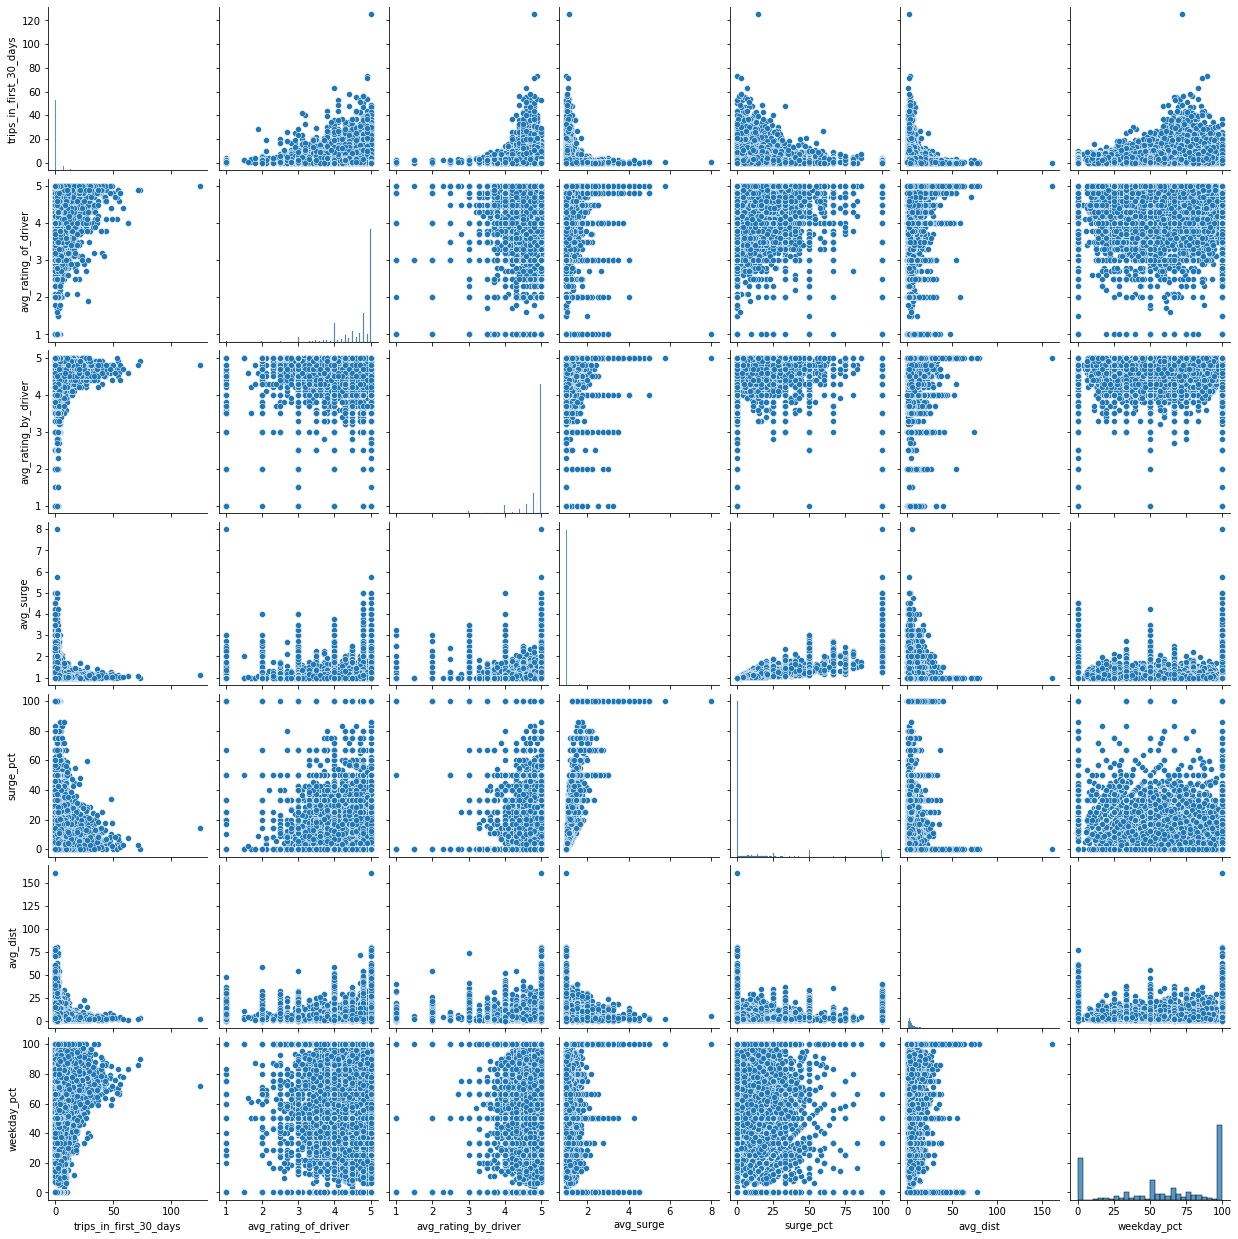

In [36]:
sns.pairplot(data,vars=['trips_in_first_30_days','avg_rating_of_driver','avg_rating_by_driver','avg_surge','surge_pct','avg_dist','weekday_pct'])

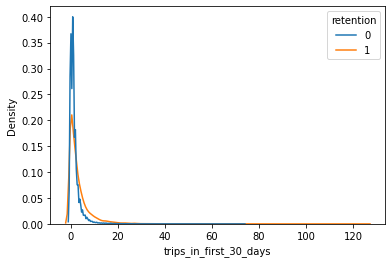

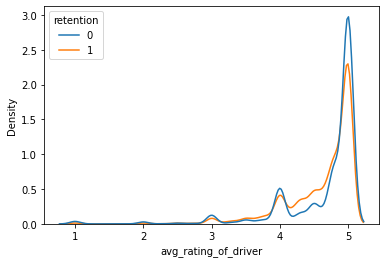

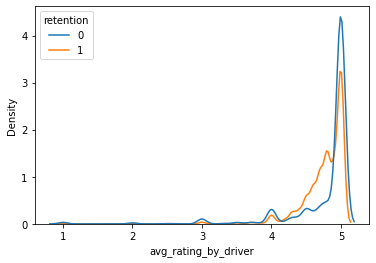

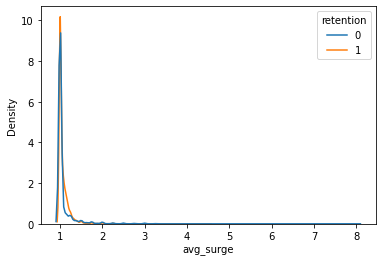

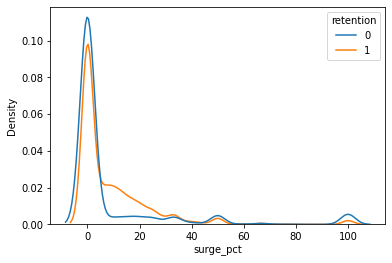

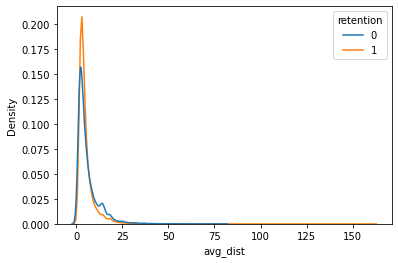

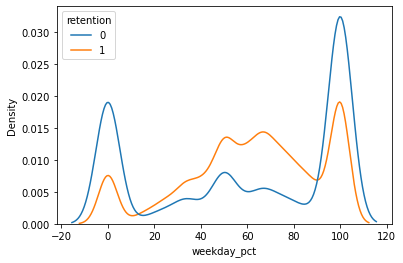

In [37]:
for col in ['trips_in_first_30_days','avg_rating_of_driver','avg_rating_by_driver','avg_surge','surge_pct','avg_dist','weekday_pct']:
    sns.kdeplot(data=data,x=col,hue='retention',common_norm=False)
    plt.show()

Positively, a lot of these plots show differences between the distributions, but most of the distributions are highly skewed.  
___
Some observations
1.  Retained customers tend to take more rides in the first 30 days.
1.  Retained customers tend to rate drivers lower and are rated lower by drivers.  
1.  Retained customers tend to have a higher number of trips that have surge pricing
1.  Lost customers tend to have 0% weekday rides or 100% weekday rides.  If weekend pct is >30 and <100 there is a greater chance that customer will be retained.  

A linear model will not be able to properly utilize `weekday_pct` given the nature of it's distribution, so I will apply a tree based model.  The tree based model can create multiple boundaries for each feature.  

Checking for correlation among numeric features

<AxesSubplot:>

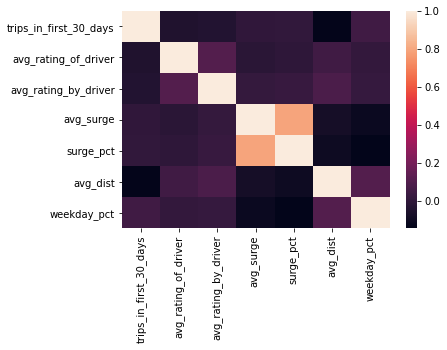

In [38]:
sns.heatmap(data[['trips_in_first_30_days','avg_rating_of_driver','avg_rating_by_driver','avg_surge','surge_pct','avg_dist','weekday_pct']].corr())

In [39]:
from scipy.stats import pearsonr
print('Pearson r: {:.3f}'.format(pearsonr(data.avg_surge,data.surge_pct)[0]))

Pearson r: 0.793


`avg_surge` and `surge_pct` are pretty highly correlated with a Pearson correlation values of 0.79.  I will leave it for now, but will check for collinearity later. 

Now prepare for modelling. 
1.  Calculate information value and reduce features accordingly
1.  Calculate multicollinearity and drop colinear features
1.  Split into train and test
1.  Apply default model
1.  Optimize
1.  Evaluate

In [40]:
rand_state = 33

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trips_in_first_30_days  49604 non-null  int64         
 1   signup_date             49604 non-null  datetime64[ns]
 2   avg_rating_of_driver    49604 non-null  float64       
 3   avg_surge               49604 non-null  float64       
 4   last_trip_date          49604 non-null  datetime64[ns]
 5   iPhone                  49604 non-null  int32         
 6   surge_pct               49604 non-null  float64       
 7   ultimate_black_user     49604 non-null  int32         
 8   weekday_pct             49604 non-null  float64       
 9   avg_dist                49604 non-null  float64       
 10  avg_rating_by_driver    49604 non-null  float64       
 11  retention               49604 non-null  int32         
 12  city_Astapor            49604 non-null  uint8 

In [42]:
data.drop(['signup_date','last_trip_date'], axis=1, inplace=True)
y = data.pop('retention')



Function for calculating weight of evidence and information value for each feature

In [43]:
### Function to calculate the Information Value (IV) of each feature
### 


max_bin = 20
force_bin = 3
import pandas.core.algorithms as algos
import scipy.stats.stats as stats
import re


# define a binning function
### this function is for binning and calculating the Weight of Evidence 
### for the target and the Information Value for the feature
### and the In
def mono_bin(Y, X, n = max_bin):    
    ### create new dataframe of series feature and series y
    df1 = pd.DataFrame({"X": X, "Y": Y})
    
    ### check to see if any nulls in feature and seperate nulls out
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    #print("justmiss", justmiss)
    #print("notmiss", notmiss)
    
    
    ### while loop until Spearman correlation coefficient is between [-1,1]
    ### Finding minumum bin size that results in 'abs(r)' of >1???
    
    r = 0
    while np.abs(r) < 1:
        ### Try creation of new dataframe with max or less bin size 'n'
        ### create dataframe with feature, target and binned feature 
        ### create 'd2' group by object on 'Bucket'
        ### calculate Spearman correlation 'r' and p-value from mean of feature and target
        ### If exception reduce bin number by one and try again
        ### Effectively finding the max bin number that can be used 
        ### for calculating WOE
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y,\
                               "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
                             
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            #print("I am here 1",r, n,len(d2))
            n = n - 1 
            
            
        except Exception as e:
            n = n - 1
            #print("I am here e",n)

    ### If length of d2 is 1 (ie 1 bucket for all of feature) do this
    if len(d2) == 1:
        #print("I am second step ",r, n)
        
        ### force 'n' to 3 and calculate quantiles of feature from (0,0.5,1) 
        ### to be used as bins, if not 3 unique because of heavily skewed data
        ### manually create bin
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
            
        ### Create new dataframe bucketed by manual bins
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    ### Create new dataframe from aggregating the binned dataframe
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        #print(justmiss.count().Y)
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    ### add more features to d3 describing the 'events' of the target
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    print(np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT))
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    #print("hi",d3.IV )
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    import traceback
    
    
    ### Extract raw traceback from error in one of the two sub functions
    ### assign traceback elemnts to variables
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    
    
    
    ###
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    
    ### get column names from df1
    x = df1.dtypes.index
    
    count = -1
    ### Loop through columns
    for i in x:
        print(i)
        if i.upper() not in (final.upper()):
            ### test if numeric and not a one-hot encoding
            if np.issubdtype(df1[i], np.number) and len(pd.Series.unique(df1[i])) > 2:
                #print("Number and unique value greater than 2")
                ###  pass target and feature to 'mono_bin'
                conv = mono_bin(target, df1[i])
                
                ### assign feature name to 'conv'
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                #print("I am here 2")
                ###  pass target and feature to 'char_bin'
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1

            ### First time run through the loop where count==0,
            ### create new df from current
            if count == 0:
                iv_df = conv
            ### on subsequent loops append rows to bottom of 'iv_df'
            ### of next feature and scoring calcs
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    ### aggregate 'iv_df' taking the maximum ?correlation? score 
    ### for each feature and creating a new summary df with columns 
    ### 'VAR_NAME' & 'IV'
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    ### return detailed df with all computed features
    ### and summary of only max values and feature names
    return(iv_df,iv)

In [44]:
iv_df, iv = data_vars(data,y)

trips_in_first_30_days
0   -0.376108
1   -0.014080
2    0.761506
dtype: float64
avg_rating_of_driver
0    0.329972
1   -0.363674
dtype: float64
avg_surge
0   -0.424340
1    0.828214
dtype: float64
iPhone
surge_pct
0   -0.424778
1    0.828143
dtype: float64
ultimate_black_user
weekday_pct
0    0.097663
1   -0.109887
dtype: float64
avg_dist
0    0.084673
1   -0.086873
dtype: float64
avg_rating_by_driver
0   -1.532192
1    0.004004
dtype: float64
city_Astapor
city_King's Landing
city_Winterfell
signup_day
0    0.025960
1   -0.026907
dtype: float64


In [45]:
iv = iv.sort_values('IV',ascending=False)
print(iv.head())

feats = list(iv.loc[(iv.IV>.01) & (iv.IV<.8),'VAR_NAME'])
X2 = data[feats]


                  VAR_NAME        IV
9                surge_pct  0.341841
3                avg_surge  0.341526
5      city_King's Landing  0.300771
7                   iPhone  0.261296
10  trips_in_first_30_days  0.239302


Function for calculating collinearity among the features.

In [46]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        
        ### Create data frame with features column and 
        ### variance inflation factor column
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns
        
        
        
        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
            #if count==45:
                #print('early stop for plotting intermediate step')
                #return df, vif.sort_values('VIFactor')  
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')  

In [47]:
final_df,vif = iterate_vif(X2)

Iteration # 1
Removing avg_surge with VIF of 36.989744
Iteration # 2
Removing avg_rating_of_driver with VIF of 7.243029
Iteration # 3
Complete


In [48]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   surge_pct               49604 non-null  float64
 1   city_King's Landing     49604 non-null  uint8  
 2   iPhone                  49604 non-null  int32  
 3   trips_in_first_30_days  49604 non-null  int64  
 4   ultimate_black_user     49604 non-null  int32  
 5   city_Astapor            49604 non-null  uint8  
 6   weekday_pct             49604 non-null  float64
dtypes: float64(2), int32(2), int64(1), uint8(2)
memory usage: 2.0 MB


After that I am left with 7 features for predicting retention. 

In [49]:
X = final_df.to_numpy()
feats = final_df.columns

In [50]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,\
                                                 test_size=.2,\
                                                 random_state=rand_state,\
                                                stratify=y)
print(f'{sum(y_train)/len(y_train):.3f}%')
print(f'{sum(y_test)/len(y_test):.3f}%')

0.367%
0.366%


In [51]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(39683, 7)
(9921, 7)
(39683,)
(9921,)


In [52]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state = rand_state)
rf_clf.fit(X_train,y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=33, verbose=0,
                       warm_start=False)

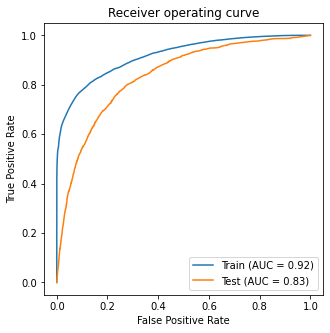

In [53]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
fig,ax = plt.subplots(figsize=(5,5))
plot_roc_curve(rf_clf,X_train,y_train,name='Train',ax=ax)
plot_roc_curve(rf_clf,X_test,y_test,name='Test',ax=ax)
plt.title('Receiver operating curve')
plt.show()


Not Bad, but the default Random Forest model's ROC curve looks a little overfit to the training data (which they tend to do).  Now I will use cross validation and grid search to avoid overfitting and optimize the hyperparameters.

In [54]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [55]:
from sklearn.model_selection import GridSearchCV
params = {'n_estimators':[30,50,80,100,120],\
         'criterion':['gini','entropy'],\
         'max_depth':[2,3,5,7]}
rf_gs = GridSearchCV(RandomForestClassifier(random_state=rand_state),\
                     param_grid=params, scoring='recall')

rf_gs.fit(X_train,y_train)

print('Best params:',rf_gs.best_params_)
print()
print(f'Best Score: {rf_gs.best_score_:.4f}')



Best params: {'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 50}

Best Score: 0.6141


An AUC of 0.84 is pretty good and indicates that the model has predictive power.  I chose recall as the scoring metric because we are focusing on the positive classes (retained) and what factors are most important for predicting retention. 

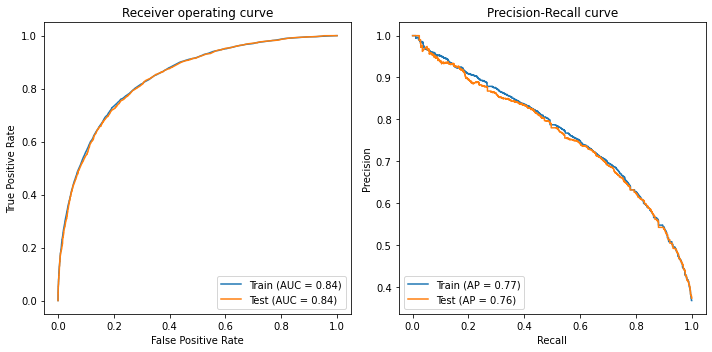

In [56]:
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve
fig,ax = plt.subplots(1,2,figsize=(10,5),tight_layout=True)
plot_roc_curve(rf_gs,X_train,y_train,name='Train',ax=ax[0])
plot_roc_curve(rf_gs,X_test,y_test,name='Test',ax=ax[0])
ax[0].set_title('Receiver operating curve')



plot_precision_recall_curve(rf_gs,X_train,y_train,name='Train',ax=ax[1])
plot_precision_recall_curve(rf_gs,X_test,y_test,name='Test',ax=ax[1])
ax[1].set_title('Precision-Recall curve')
plt.show()

That looks much better. Using cross validation, and optimizing the hyper parameters results in a slightly higher AUC for the test set and no signs of overfitting.  Limiting the depth of the trees in the forest probably accounts for a lot of that.


___
Now a quick look at the confusion matrix.

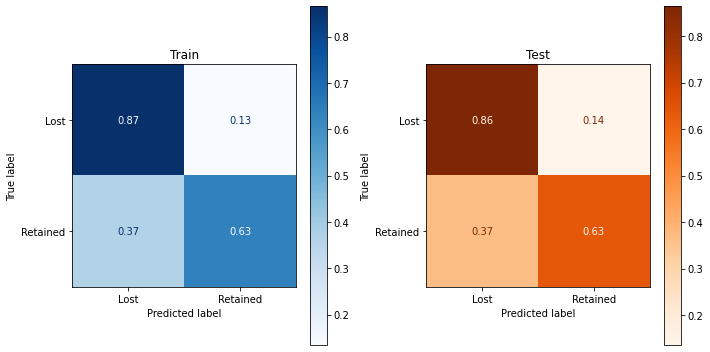

Train Precision 0.731
Train Recall    0.635
Train F1    0.680

Test Precision  0.729
Test Recall     0.634
Train F1    0.678


In [57]:
from sklearn.metrics import plot_confusion_matrix,precision_score,recall_score,f1_score

fig,ax = plt.subplots(1,2,figsize=(10,5),tight_layout=True)
plot_confusion_matrix(rf_gs,X_train,y_train,display_labels=['Lost','Retained'],normalize='true',ax=ax[0],cmap='Blues')
plot_confusion_matrix(rf_gs,X_test,y_test,display_labels=['Lost','Retained'],normalize='true',ax=ax[1],cmap='Oranges')
ax[0].set_title('Train')
ax[1].set_title('Test')
plt.show()

### Training
print('Train Precision {:.3f}'.format(precision_score(\
                          y_train,rf_gs.predict(X_train))))
print('Train Recall    {:.3f}'.format(recall_score(\
                           y_train,rf_gs.predict(X_train))))
print('Train F1    {:.3f}'.format(f1_score(\
                           y_train,rf_gs.predict(X_train))))

print()
### Testing
print('Test Precision  {:.3f}'.format(precision_score(\
                          y_test,rf_gs.predict(X_test))))
print('Test Recall     {:.3f}'.format(recall_score(\
                               y_test,rf_gs.predict(X_test))))
print('Train F1    {:.3f}'.format(f1_score(\
                           y_test,rf_gs.predict(X_test))))

The confusion matrices again demonstrate there is no overfitting to the test set.

The model generalizes well to the training data has predictive power as demonstrated by the AUC of 0.85 for the test set.  I am a little concerned about using 2 somewhat correlated features in `avg_surge` and `surge_pct`.  That could be re done by calculating the information value of each and one then keeping the one with the highest value.  
___ 
The goal is to determine which factors are the best predictors of retention, so now digging into feature importance.

In [58]:
feat_import = pd.DataFrame(zip(feats,rf_gs.best_estimator_.feature_importances_),columns=['feature','importance'])
feat_import.set_index('feature').sort_values('importance',ascending=False)

,importance
feature,
surge_pct,0.237378
weekday_pct,0.235050
city_King's Landing,0.167338
iPhone,0.130769
trips_in_first_30_days,0.101344
ultimate_black_user,0.089740
city_Astapor,0.038380


The most important feature in prediction is `avg_rating_by_driver`.  Other quite important features are `surge_pct`, `city_King's Landing` and `weekday_pct`.  That is not too surprising becuase there were differences in those distributions identified above.  

In [59]:
import shap

shap_values = shap.TreeExplainer(rf_gs.best_estimator_).shap_values(X_train)


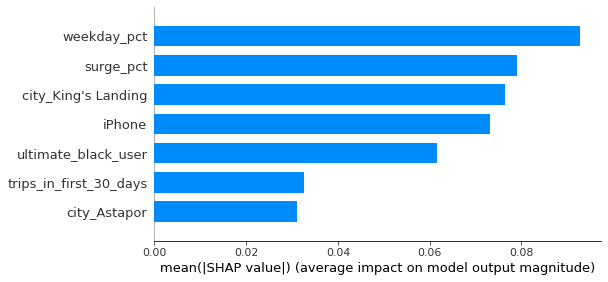

In [60]:
shap.summary_plot(shap_values[1], X_train, plot_type="bar",\
                  feature_names=feats, class_names=['lost','retained'],\
                 )


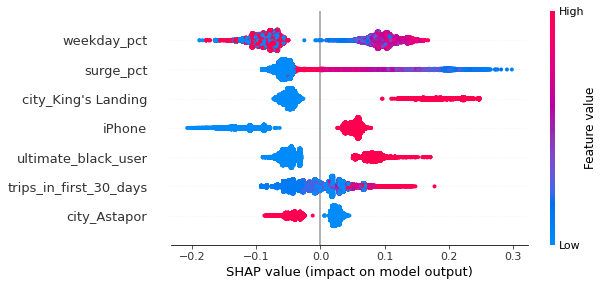

In [61]:
shap.summary_plot(shap_values[1], X_train,\
                  feature_names=feats,\
                  class_names=['lost','retained'])


Some observations of the shap values.
1.  The effect of `weekday_pct` is large and complicated. Further discussion below. 
1.  The effect of `surge_pct` is also complicated and non-linear, which wasn't identified earlier.  
1.  Users in King's Landing are more likely to be retained than those in other cities.  
1.  Users with iPhones are more likely to be retained than users with Android devices.  
1.  Users that took a higher number of Ultimate Black rides in their first 30 days are more likely to be retained.  
1.  The `trips_in_first_30days` has a significant and expected impact on the prediction. The more trips in the first 30 days, the more likely the user will be retained.
1.  Users in the city of Astapor are less likely to be retained.  
1.  I didn't acknowledge it above but the ratings of the driver and by the driver didn't matter at all for the prediction.  
I will interpret these observations in the summary below.

In [62]:
feat_cols = {k:v for v,k in enumerate(feats)}
feat_cols

{'surge_pct': 0,
 "city_King's Landing": 1,
 'iPhone': 2,
 'trips_in_first_30_days': 3,
 'ultimate_black_user': 4,
 'city_Astapor': 5,
 'weekday_pct': 6}

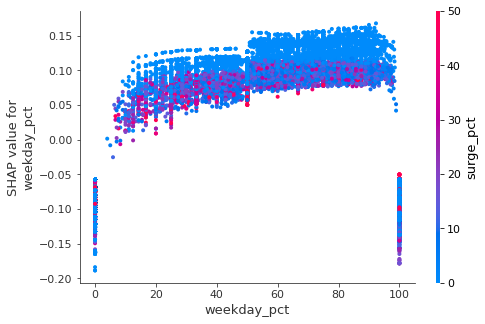

In [63]:
#shap.plots.scatter(shap_values[0][:,list(data.columns).index('weekday_pct')], color =shap_values)
shap.dependence_plot(feat_cols['weekday_pct'],shap_values[1],X_train,\
                     feature_names=feats,\
                     interaction_index=feat_cols['surge_pct'])

The above plot shows the impact of `weekday_pct` on the model. The x-axis shows the values of `weekday_pct` column and the y-axis shows its impact on the prediction of a positive case (retained user).  If a users percentage of rides on weekdays is 0% or 100% then the user is more likely to be lost than a user whose weekday percentage is somewhere in between. 

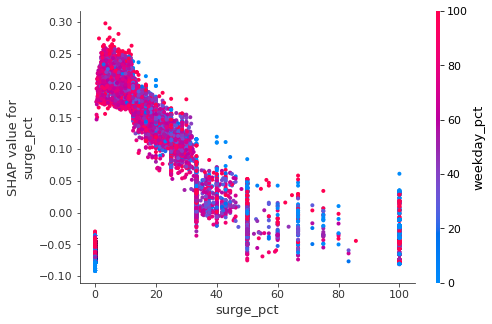

In [64]:
#shap.plots.scatter(shap_values[0][:,list(data.columns).index('weekday_pct')], color =shap_values)
shap.dependence_plot(feat_cols['surge_pct'],shap_values[1],X_train,\
                     feature_names=feats,\
                     interaction_index=feat_cols['weekday_pct'])

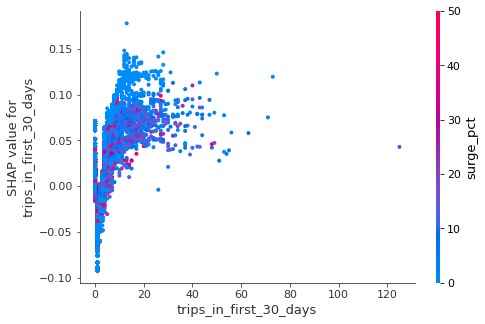

In [65]:
#shap.plots.scatter(shap_values[0][:,list(data.columns).index('weekday_pct')], color =shap_values)
shap.dependence_plot(feat_cols['trips_in_first_30_days'],shap_values[1],X_train,\
                     feature_names=feats,\
                     interaction_index=feat_cols['surge_pct'])

### Part 3 - Recommendations
There were several interesting insights gleaned from the classification model.  The most important features for predicting retention are, `weekday_pct`, `surge_pct`, `city_King's Landing`, `iPhone`.
- Users with a weekday percentage of rides greater than 0% and less than 100% are more likely to be retained.  This probably reflects demographics or customer behavior.  
- Users who took a higher percentage of rides that were subject to surge pricing were more likely to be retained.  Again, this could be a reflection of demographics and behavior, but this learning could be used by the marketing department to emphasize how useful the service can be during surge times/events.
- The users in King's Landing have a high retention rate.  Marketing efforts could be focused on Winterfell and Astapor which have lower retention rates. 
- Users with iPhones are far more likely to be retained than users with Android device.  I recommend Ultimate revisit their Android app and see if the user experience can be improved.  
- Users who used Ultimate Black in the first 30 days are more likely to be retained than those that did not.  Ultimate could start sending notifications to new users raising awareness of the Ultimate Black service.  Even better, we could run a randomized experiment to see if these notifications wold improve retention.
- Users who took more trips in their first 30 days are more likely to be retained.  Ultimate could could send notifications in the app to new users to try to boost the number of rides a user takes in their first 30 days. 

